# Day 5: Cross-Sectional Regression for Factor Models

## 🎯 Learning Objectives
- Apply regression across assets (not time)
- Estimate factor risk premia
- Build Fama-MacBeth regression framework
- Understand alpha generation from cross-sectional models

---

## 📚 Theory: Cross-Sectional Regression

### Time-Series vs Cross-Sectional
| Aspect | Time-Series | Cross-Sectional |
|--------|-------------|----------------|
| Unit | Single asset over time | Multiple assets at time t |
| Question | How does AAPL depend on factors? | Which factor exposures predict returns? |
| Output | Factor loadings (betas) | Factor risk premia (lambdas) |

### Fama-MacBeth Two-Pass Regression

**Pass 1 (Time-Series)**: Estimate factor loadings for each asset
$$R_{i,t} - R_f = \alpha_i + \beta_{i,1}F_{1,t} + ... + \beta_{i,k}F_{k,t} + \epsilon_{i,t}$$

**Pass 2 (Cross-Sectional)**: At each time t, regress returns on betas
$$R_{i,t} = \gamma_{0,t} + \gamma_{1,t}\hat{\beta}_{i,1} + ... + \gamma_{k,t}\hat{\beta}_{i,k} + \eta_{i,t}$$

**Factor Risk Premia**: Average of cross-sectional slopes
$$\hat{\lambda}_k = \frac{1}{T}\sum_{t=1}^T \gamma_{k,t}$$

### Why It Matters for Trading
- Identify which factors are priced (earn risk premia)
- Find stocks with mispriced factor exposures
- Build factor-based trading strategies

---

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05 / TRADING_DAYS  # Daily

# Download diversified stock universe
tickers = [
    # Tech
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'AMD', 'INTC',
    # Finance
    'JPM', 'BAC', 'GS', 'MS', 'C', 'WFC',
    # Healthcare
    'JNJ', 'PFE', 'UNH', 'MRK',
    # Consumer
    'WMT', 'PG', 'KO', 'PEP', 'MCD',
    # Energy
    'XOM', 'CVX',
    # Market ETF
    'SPY'
]

end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading stock data...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close'].dropna()
returns = prices.pct_change().dropna()

# Remove SPY from stock universe (it's a factor)
market_return = returns['SPY']
stock_returns = returns.drop(columns=['SPY'])

print(f"✅ Universe: {len(stock_returns.columns)} stocks")
print(f"📅 Period: {returns.index[0].strftime('%Y-%m-%d')} to {returns.index[-1].strftime('%Y-%m-%d')}")

📥 Downloading stock data...
✅ Universe: 25 stocks
📅 Period: 2021-01-26 to 2026-01-21


In [2]:
# Create Factor Data
factors = pd.DataFrame(index=returns.index)

# Market Factor (excess return)
factors['MKT'] = market_return - RISK_FREE_RATE

# Size Factor (SMB proxy): Small minus Big based on market cap ranking
# Use price as proxy for size (imperfect but illustrative)
median_price = prices[stock_returns.columns].median(axis=1)
small_stocks = (prices[stock_returns.columns].T < median_price).T
big_stocks = ~small_stocks

small_ret = (stock_returns * small_stocks).mean(axis=1)
big_ret = (stock_returns * big_stocks).mean(axis=1)
factors['SMB'] = small_ret - big_ret

# Momentum Factor (WML): Winners minus Losers
momentum_12m = stock_returns.rolling(252).sum().shift(21)  # 12m momentum, skip recent month
momentum_rank = momentum_12m.rank(axis=1, pct=True)
winners = momentum_rank > 0.7
losers = momentum_rank < 0.3

winner_ret = (stock_returns * winners).mean(axis=1)
loser_ret = (stock_returns * losers).mean(axis=1)
factors['MOM'] = winner_ret - loser_ret

factors = factors.dropna()
print(f"\n📊 Created {len(factors.columns)} factors")
print(factors.describe().T[['mean', 'std']])


📊 Created 3 factors
         mean       std
MKT  0.000376  0.010784
SMB -0.000101  0.003456
MOM  0.000130  0.003901


In [3]:
# PASS 1: Time-Series Regression (Estimate Betas)
# Rolling window for time-varying betas
estimation_window = 252  # 1 year

# Align data
aligned_returns = stock_returns.loc[factors.index]

# Store betas for each stock
all_betas = {}

print("\nEstimating factor betas for each stock...")
for stock in aligned_returns.columns:
    stock_betas = []
    
    # Rolling regression
    for end_idx in range(estimation_window, len(factors)):
        start_idx = end_idx - estimation_window
        
        y = aligned_returns[stock].iloc[start_idx:end_idx].values
        X = factors.iloc[start_idx:end_idx].values
        X = sm.add_constant(X)
        
        try:
            model = sm.OLS(y, X).fit()
            betas = model.params[1:]  # Exclude intercept
        except:
            betas = np.zeros(len(factors.columns))
        
        stock_betas.append(betas)
    
    all_betas[stock] = np.array(stock_betas)

# Create beta DataFrames
beta_dates = factors.index[estimation_window:]
beta_mkt = pd.DataFrame({s: all_betas[s][:, 0] for s in aligned_returns.columns}, index=beta_dates)
beta_smb = pd.DataFrame({s: all_betas[s][:, 1] for s in aligned_returns.columns}, index=beta_dates)
beta_mom = pd.DataFrame({s: all_betas[s][:, 2] for s in aligned_returns.columns}, index=beta_dates)

print(f"\n✅ Estimated betas for {len(beta_dates)} periods")


Estimating factor betas for each stock...

✅ Estimated betas for 1001 periods


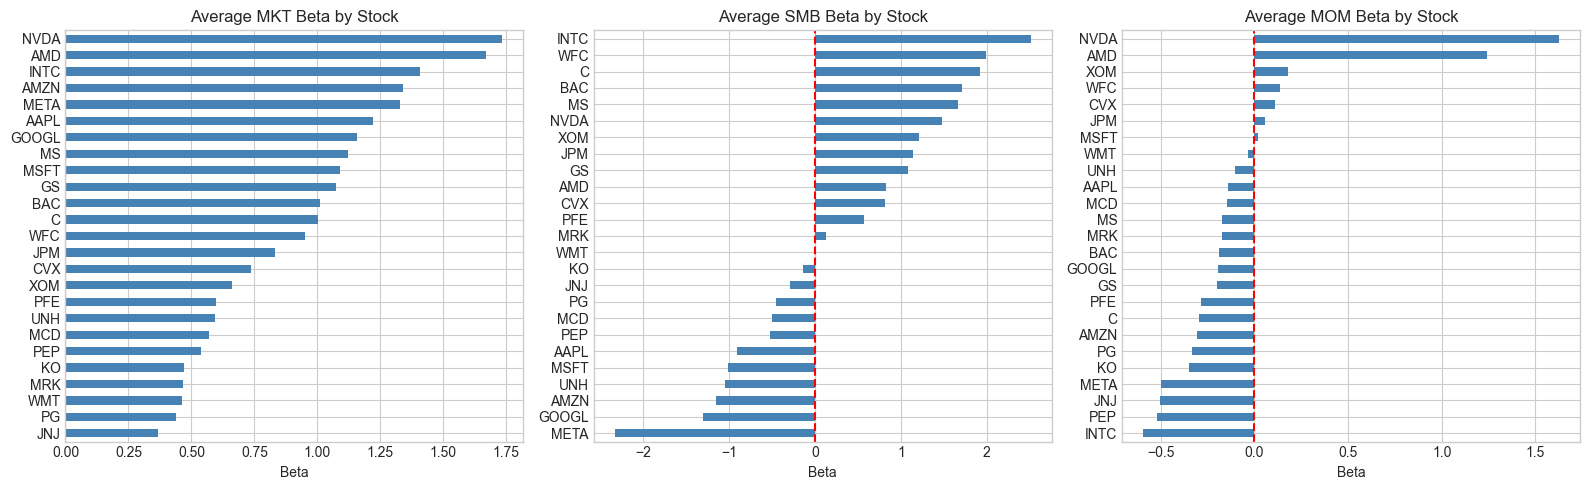

In [4]:
# Visualize average betas by stock
avg_betas = pd.DataFrame({
    'MKT': beta_mkt.mean(),
    'SMB': beta_smb.mean(),
    'MOM': beta_mom.mean()
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, factor in enumerate(['MKT', 'SMB', 'MOM']):
    avg_betas[factor].sort_values().plot(kind='barh', ax=axes[i], color='steelblue')
    axes[i].axvline(x=0, color='r', linestyle='--')
    axes[i].set_title(f'Average {factor} Beta by Stock')
    axes[i].set_xlabel('Beta')

plt.tight_layout()
plt.show()

In [5]:
# PASS 2: Cross-Sectional Regression (Estimate Risk Premia)
# For each period, regress returns on betas

aligned_returns_pass2 = aligned_returns.loc[beta_dates]

# Store cross-sectional gammas
gammas = []

for t in beta_dates:
    # Get returns at time t
    y = aligned_returns_pass2.loc[t].values
    
    # Get betas at time t
    X = np.column_stack([
        beta_mkt.loc[t].values,
        beta_smb.loc[t].values,
        beta_mom.loc[t].values
    ])
    X = sm.add_constant(X)
    
    try:
        model = sm.OLS(y, X).fit()
        gammas.append(model.params)
    except:
        gammas.append(np.zeros(4))

gammas = np.array(gammas)
gamma_df = pd.DataFrame(gammas, index=beta_dates, columns=['Intercept', 'MKT', 'SMB', 'MOM'])

print("\n" + "="*60)
print("CROSS-SECTIONAL REGRESSION RESULTS")
print("="*60)


CROSS-SECTIONAL REGRESSION RESULTS


In [6]:
# Calculate Factor Risk Premia (Fama-MacBeth)
risk_premia = gamma_df.mean()
risk_premia_std = gamma_df.std() / np.sqrt(len(gamma_df))  # Standard error
t_stats = risk_premia / risk_premia_std

print("\n" + "="*60)
print("FAMA-MACBETH FACTOR RISK PREMIA (Daily)")
print("="*60)
print(f"\n{'Factor':<12} {'Risk Premium':>15} {'Std Error':>12} {'t-stat':>10} {'Sig':>5}")
print("-" * 55)

for factor in gamma_df.columns:
    rp = risk_premia[factor]
    se = risk_premia_std[factor]
    t = t_stats[factor]
    sig = '***' if abs(t) > 2.58 else '**' if abs(t) > 1.96 else '*' if abs(t) > 1.64 else ''
    print(f"{factor:<12} {rp:>15.6f} {se:>12.6f} {t:>10.2f} {sig:>5}")

print("\n* p<0.10, ** p<0.05, *** p<0.01")

# Annualized risk premia
print(f"\n📊 Annualized Risk Premia:")
for factor in ['MKT', 'SMB', 'MOM']:
    annual_rp = risk_premia[factor] * TRADING_DAYS
    print(f"   {factor}: {annual_rp:.2%}")


FAMA-MACBETH FACTOR RISK PREMIA (Daily)

Factor          Risk Premium    Std Error     t-stat   Sig
-------------------------------------------------------
Intercept          -0.000520     0.000431      -1.20      
MKT                 0.001326     0.000563       2.35    **
SMB                 0.000138     0.000135       1.02      
MOM                -0.000118     0.000182      -0.65      

* p<0.10, ** p<0.05, *** p<0.01

📊 Annualized Risk Premia:
   MKT: 33.41%
   SMB: 3.47%
   MOM: -2.97%


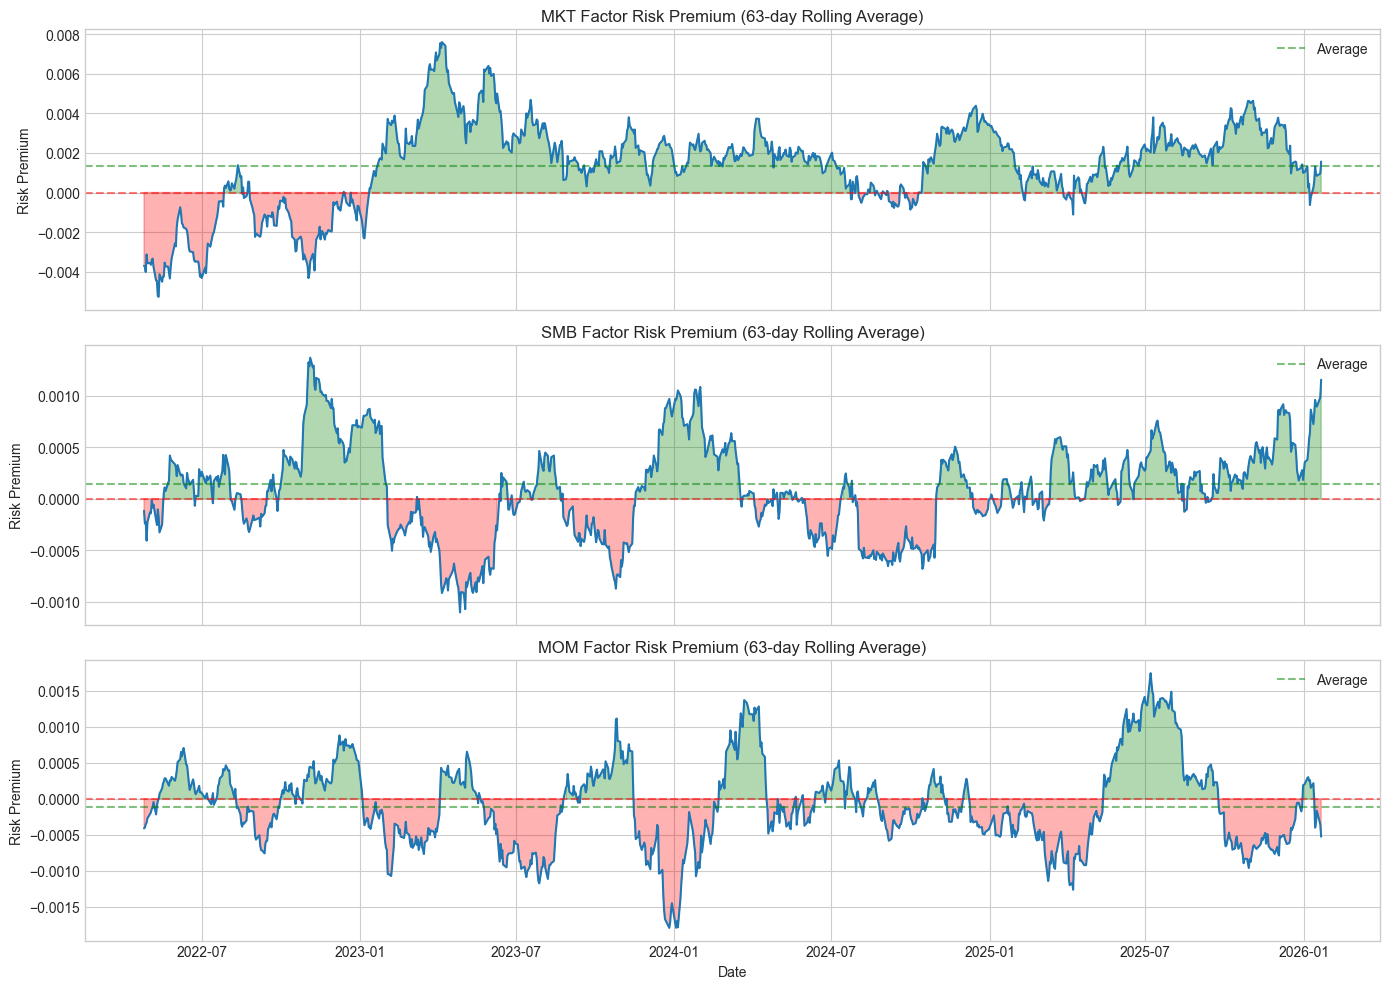

In [7]:
# Visualize time-varying risk premia
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, factor in enumerate(['MKT', 'SMB', 'MOM']):
    rolling_gamma = gamma_df[factor].rolling(63).mean()  # Quarterly rolling
    axes[i].plot(rolling_gamma.index, rolling_gamma.values, linewidth=1.5)
    axes[i].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[i].axhline(y=risk_premia[factor], color='green', linestyle='--', alpha=0.5, label='Average')
    axes[i].set_title(f'{factor} Factor Risk Premium (63-day Rolling Average)')
    axes[i].set_ylabel('Risk Premium')
    axes[i].legend()
    axes[i].fill_between(rolling_gamma.index, rolling_gamma.values, 0, 
                        where=rolling_gamma.values > 0, alpha=0.3, color='green')
    axes[i].fill_between(rolling_gamma.index, rolling_gamma.values, 0, 
                        where=rolling_gamma.values < 0, alpha=0.3, color='red')

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [8]:
# Trading Strategy: Long High-Beta, Short Low-Beta
# For each factor, rank stocks and build long-short portfolios

def build_factor_portfolio(beta_df, returns_df, factor_name):
    """Build long-short portfolio based on factor beta."""
    portfolio_returns = []
    
    for t in beta_df.index[:-1]:  # Exclude last day
        next_t = returns_df.index[returns_df.index.get_loc(t) + 1]
        
        # Rank stocks by beta
        betas = beta_df.loc[t]
        
        # Top and bottom tercile
        high_beta = betas.nlargest(len(betas)//3).index
        low_beta = betas.nsmallest(len(betas)//3).index
        
        # Long-short return
        long_ret = returns_df.loc[next_t, high_beta].mean()
        short_ret = returns_df.loc[next_t, low_beta].mean()
        ls_ret = long_ret - short_ret
        
        portfolio_returns.append({'date': next_t, 'return': ls_ret})
    
    return pd.DataFrame(portfolio_returns).set_index('date')['return']

# Build portfolios
mkt_port = build_factor_portfolio(beta_mkt, aligned_returns_pass2, 'MKT')
smb_port = build_factor_portfolio(beta_smb, aligned_returns_pass2, 'SMB')
mom_port = build_factor_portfolio(beta_mom, aligned_returns_pass2, 'MOM')

print("\n" + "="*60)
print("FACTOR PORTFOLIO PERFORMANCE (Long High-Beta, Short Low-Beta)")
print("="*60)


FACTOR PORTFOLIO PERFORMANCE (Long High-Beta, Short Low-Beta)


Strategy  Ann. Return  Ann. Vol    Sharpe  Total Return
MKT Beta     0.311815  0.290594  0.900965      1.915439
SMB Beta     0.199068  0.207054  0.719948      1.023288
MOM Beta    -0.113481  0.252449 -0.647581     -0.438858


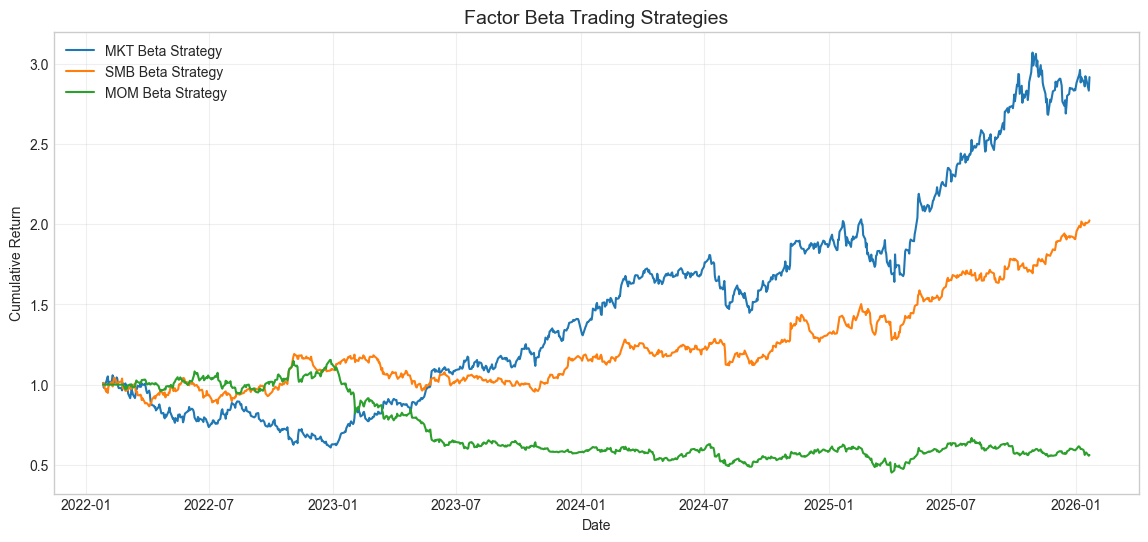

In [9]:
# Calculate and display performance
def calc_performance(returns, name):
    ann_ret = returns.mean() * TRADING_DAYS
    ann_vol = returns.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_ret - 0.05) / ann_vol if ann_vol > 0 else 0
    cum_ret = (1 + returns).cumprod().iloc[-1] - 1
    return {'Strategy': name, 'Ann. Return': ann_ret, 'Ann. Vol': ann_vol, 
            'Sharpe': sharpe, 'Total Return': cum_ret}

perf = pd.DataFrame([
    calc_performance(mkt_port, 'MKT Beta'),
    calc_performance(smb_port, 'SMB Beta'),
    calc_performance(mom_port, 'MOM Beta')
])

print(perf.to_string(index=False))

# Plot cumulative returns
plt.figure(figsize=(14, 6))
plt.plot((1 + mkt_port).cumprod(), label='MKT Beta Strategy')
plt.plot((1 + smb_port).cumprod(), label='SMB Beta Strategy')
plt.plot((1 + mom_port).cumprod(), label='MOM Beta Strategy')
plt.title('Factor Beta Trading Strategies', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [10]:
# Current Factor Signals
latest_date = beta_dates[-1]

print("\n" + "="*60)
print(f"📊 CURRENT FACTOR SIGNALS ({latest_date.strftime('%Y-%m-%d')})")
print("="*60)

# Stocks with highest/lowest factor exposures
for factor, beta_df in [('MKT', beta_mkt), ('SMB', beta_smb), ('MOM', beta_mom)]:
    latest_betas = beta_df.loc[latest_date].sort_values()
    print(f"\n{factor} Factor:")
    print(f"  📈 Highest: {', '.join(latest_betas.nlargest(3).index.tolist())}")
    print(f"  📉 Lowest: {', '.join(latest_betas.nsmallest(3).index.tolist())}")


📊 CURRENT FACTOR SIGNALS (2026-01-21)

MKT Factor:
  📈 Highest: AMD, NVDA, INTC
  📉 Lowest: KO, JNJ, MCD

SMB Factor:
  📈 Highest: INTC, WFC, BAC
  📉 Lowest: UNH, AMD, GOOGL

MOM Factor:
  📈 Highest: NVDA, MS, C
  📉 Lowest: MRK, UNH, PEP


---

## 🏢 Real-World Applications

| Company | Cross-Sectional Regression Use |
|---------|-------------------------------|
| AQR Capital | Factor risk premia estimation |
| Dimensional Fund Advisors | Size & value premia research |
| MSCI Barra | Risk model construction |
| BlackRock | Factor-based ETF design |

### Key Interview Points
1. **Why Fama-MacBeth?** - Accounts for cross-sectional correlation in residuals
2. **Errors-in-variables?** - Estimated betas have measurement error → use portfolios
3. **Time-varying premia?** - Risk premia are not constant, especially in crises

---
## 📅 Tomorrow: Weighted Least Squares & Robust Regression